### Расчет метрик

In [24]:
from collections import defaultdict, Counter
import typing as tp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

np.seterr(divide='ignore')


def calculate_metrics(df, group_columns: tp.List[str], judgement_col='correct_judgement', workers_col='workers_judgement', binary_threshold=1.0, seed=239) -> tp.Dict:
    df = df.copy(deep=True)
    def calc_ndcg(df, workers_col, judgement_col):
        sorted_best = [x[0] for x in sorted(zip(df[judgement_col].to_list(), df['rnd'].to_list()), reverse=True)]
        sorted_ans = [x[-1] for x in sorted(zip(df[workers_col].to_list(), df['rnd'].to_list(), df[judgement_col].to_list()), reverse=True)]
        dcg = sum(x / (i + 1) for i, x in enumerate(sorted_ans))
        idcg = sum(x / (i + 1) for i, x in enumerate(sorted_best))
        return dcg / idcg if idcg != 0 else 1

    def calc_pair_rate(df, workers_col, judgement_col):
        correct_pairs_cnt = 0
        pairs_cnt = 0
        sinsig_by_url = defaultdict(float)
        lead_sinsig_by_url = defaultdict(float)
        for _, row in df.iterrows():
            sinsig = row[workers_col]
            lead_sinsig = row[judgement_col]
            url = row['url']
            sinsig_by_url[url] = sinsig
            lead_sinsig_by_url[url] = lead_sinsig
        urls = df['url'].to_list()
        for i, url in enumerate(urls):
            for url2 in urls[i+1:]:
                if lead_sinsig_by_url[url] == lead_sinsig_by_url[url2]:
                    continue
                pairs_cnt += 1
                if sinsig_by_url[url] == sinsig_by_url[url2]:
                    correct_pairs_cnt += 0.5
                elif lead_sinsig_by_url[url] < lead_sinsig_by_url[url2]:
                    correct_pairs_cnt += sinsig_by_url[url] < sinsig_by_url[url2]
                else:
                    correct_pairs_cnt += sinsig_by_url[url] > sinsig_by_url[url2]
        return correct_pairs_cnt / pairs_cnt if pairs_cnt > 0 else 1
    
    for column in group_columns:
        assert column in df.columns, f'Column {column} not found in the table'
    assert judgement_col in df.columns, f'Column {column} not found in the table'
    assert workers_col in df.columns, f'Column {column} not found in the table'
    
    np.random.seed(seed)
    df['rnd'] = np.random.random(size=len(df))
    df['dummy'] = 1
    group_columns.append('dummy')
    cols_to_add = []
    if 'query' not in group_columns:
        cols_to_add.append('query')
    df_res = df.groupby(by=group_columns + cols_to_add, as_index=False).apply(
        lambda x: pd.Series({
            'NDCG': calc_ndcg(x, workers_col, judgement_col),
            'MSE': ((x[judgement_col] - x[workers_col]) ** 2).mean(),
            'pair_rate': calc_pair_rate(x, workers_col, judgement_col),
            'tp': ((x[judgement_col] >= 0.8) * (x[workers_col] >= binary_threshold)).sum(),
            'fp': ((x[judgement_col] < 0.8) * (x[workers_col] >= binary_threshold)).sum(),
            'tn': ((x[judgement_col] < 0.8) * (x[workers_col] < binary_threshold)).sum(),
            'fn': ((x[judgement_col] >= 0.8) * (x[workers_col] < binary_threshold)).sum(),
            'n_urls': len(x),
        })
    ).groupby(by=group_columns, as_index=False).apply(
        lambda x: pd.Series({
            'NDCG': np.round(x['NDCG'].mean(), 3),
            'RMSE': np.round((x['MSE'].mean()) ** 0.5, 3),
            'pair_rate': np.round(x['pair_rate'].mean(), 3),
            'F1-score': np.round(2 * x['tp'].sum() / (2 * x['tp'] + x['fp'] + x['fn']).sum(), 2),
            'accuracy': np.round((x['tp'] + x['tn']).sum() / (x['tp'] + x['fp'] + x['tn'] + x['fn']).sum(), 3),
            'yes_precision': np.round(x['tp'].sum() / (x['tp'] + x['fp']).sum(), 3),
            'yes_recall': np.round(x['tp'].sum() / (x['tp'] + x['fn']).sum(), 3),
            'no_precision': np.round(x['tn'].sum() / (x['tn'] + x['fn']).sum(), 3),
            'no_recall': np.round(x['tn'].sum() / (x['tn'] + x['fp']).sum(), 3),
            'stats': {
                'n_urls': int(x['n_urls'].sum()),
                'n_queries': len(x),
                'positive_lead_answers': int((x['tp'] + x['fn']).sum()),
                'negative_lead_answers': int((x['fp'] + x['tn']).sum()),
            }
        })
    )
    cols = [x for x in df_res.columns.values if x != 'dummy']
    return df_res[cols]

In [25]:
data = pd.read_csv('data.csv')
calculate_metrics(data, group_columns=[])

,NDCG,RMSE,pair_rate,F1-score,accuracy,yes_precision,yes_recall,no_precision,no_recall,stats
0,0.951,0.374,0.797,0.83,0.786,0.82,0.833,0.73,0.711,"{'n_urls': 500, 'n_queries': 170, 'positive_le..."


### Симуляция ухудшения разметки

In [27]:
rmse_distribution = []
mae_distribution = []
accuracy_distribution = []
f1_score_distribution = []

np.random.seed(239)

res_data = data[['workers_judgement', 'correct_judgement']].to_numpy()

for x in tqdm(range(10000)):
    rand_indices = np.random.choice(len(res_data), size=len(res_data))
    sample = res_data[rand_indices]

    rmse_distribution.append(np.sqrt(((sample[:, 0] - sample[:, 1]) ** 2).mean()))
    mae_distribution.append(np.abs((sample[:, 0] - sample[:, 1])).mean())
    tp = ((sample[:, 0] >= 1.0) & (sample[:, 1] >= 0.8)).sum()
    fp = ((sample[:, 0] >= 1.0) & (sample[:, 1] < 0.8)).sum()
    tn = ((sample[:, 0] < 1.0) & (sample[:, 1] < 0.8)).sum()
    fn = ((sample[:, 0] < 1.0) & (sample[:, 1] >= 0.8)).sum()
    accuracy_distribution.append(((sample[:, 0] >= 1.0) == (sample[:, 1] >= 0.8)).mean())
    f1_score_distribution.append(2 * tp / (2 * tp + fp + fn))

100%|██████████| 10000/10000 [00:00<00:00, 26751.50it/s]


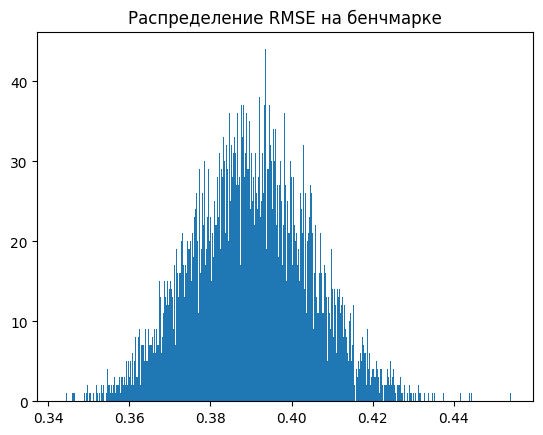

In [30]:
plt.hist(rmse_distribution, bins=1000)
plt.title('Распределение RMSE на бенчмарке')
plt.show()

In [38]:
def calculate_sensitivity_random(df, markup_rate):
    np.random.seed(239)
    data = df[['workers_judgement', 'correct_judgement']].to_numpy()
    answers_distribution = df['workers_judgement'].to_numpy()
    rmse_values = []
    mae_values = []
    accuracy_values = []
    f1_score_values = []

    def p_value(data, val):
        return (data >= val).sum() / len(data)

    for x in range(10000):
        rand_indices = np.random.choice(len(data), size=len(data))
        sample = data[rand_indices]
        changed_data_size = int(markup_rate * len(data))
        rand_markup_indices = np.random.choice(len(data), size=changed_data_size, replace=False)
        sample[rand_markup_indices, 0] = np.random.choice(answers_distribution, size=changed_data_size)

        rmse_values.append(np.sqrt(((sample[:, 0] - sample[:, 1]) ** 2).mean()))
        mae_values.append(np.abs((sample[:, 0] - sample[:, 1])).mean())
        tp = ((sample[:, 0] >= 1.0) & (sample[:, 1] >= 0.8)).sum()
        fp = ((sample[:, 0] >= 1.0) & (sample[:, 1] < 0.8)).sum()
        tn = ((sample[:, 0] < 1.0) & (sample[:, 1] < 0.8)).sum()
        fn = ((sample[:, 0] < 1.0) & (sample[:, 1] >= 0.8)).sum()
        accuracy_values.append(((sample[:, 0] >= 1.0) == (sample[:, 1] >= 0.8)).mean())
        f1_score_values.append(2 * tp / (2 * tp + fp + fn))

    p_values_rmse = [p_value(rmse_distribution, x) for x in rmse_values]
    sensitivity_rmse = sum(x <= 0.05 for x in p_values_rmse) / len(p_values_rmse)

    p_values_mae = [p_value(mae_distribution, x) for x in mae_values]
    sensitivity_mae = sum(x <= 0.05 for x in p_values_mae) / len(p_values_mae)
    
    p_values_accuracy = [1 - p_value(accuracy_distribution, x) for x in accuracy_values]
    sensitivity_accuracy = sum(x <= 0.05 for x in p_values_accuracy) / len(p_values_accuracy)

    p_values_f1_score = [1 - p_value(f1_score_distribution, x) for x in f1_score_values]
    sensitivity_f1_score = sum(x <= 0.05 for x in p_values_f1_score) / len(p_values_f1_score)

    return {
        'rmse_sensitivity': sensitivity_rmse,
        'mae_sensitivity': sensitivity_mae,
        'accuracy_sensitivity': sensitivity_accuracy,
        'f1_score_sensitivity': sensitivity_f1_score,
    }

In [39]:
rmse_sensitivities = []
mae_sensitivities = []
accuracy_sensitivities = []
f1_score_sensitivities = []

for x in tqdm(range(0, 21)):
    res = calculate_sensitivity_random(data, x / 100)
    rmse_sensitivities.append(res['rmse_sensitivity'])
    mae_sensitivities.append(res['mae_sensitivity'])
    accuracy_sensitivities.append(res['accuracy_sensitivity'])
    f1_score_sensitivities.append(res['f1_score_sensitivity'])

100%|██████████| 21/21 [03:13<00:00,  9.22s/it]


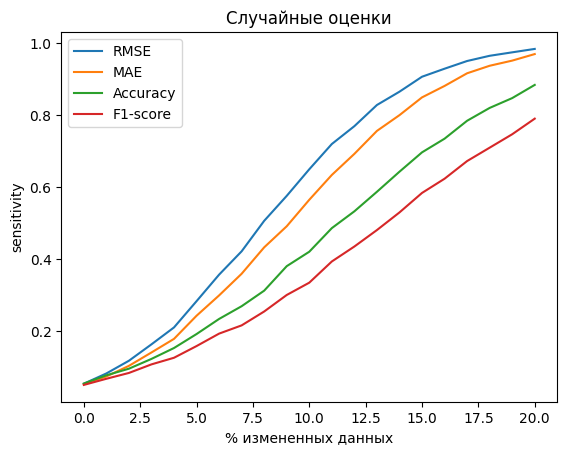

In [40]:
plt.plot(range(0, 21), rmse_sensitivities, label='RMSE')
plt.plot(range(0, 21), mae_sensitivities, label='MAE')
plt.plot(range(0, 21), accuracy_sensitivities, label='Accuracy')
plt.plot(range(0, 21), f1_score_sensitivities, label='F1-score')

plt.legend()
plt.title('Случайные оценки')
plt.xlabel('% измененных данных')
plt.ylabel('sensitivity')
plt.show()